In [167]:
import os
import json
import random
import copy
import datasets
from PIL import Image, ImageDraw
import numpy as np
from transformers import VisionEncoderDecoderModel, AutoFeatureExtractor, AutoTokenizer, ViTFeatureExtractor
import torch

import matplotlib.pyplot as plt

os.environ["WANDB_DISABLED"] = "true"

In [2]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

In [3]:
enc_args = {"output_attentions": True}

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning", output_attentions=True)
model.config.encoder.output_attentions = True
model.config.encoder.output_hidden_states = True
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
print(type(feature_extractor))
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams, "output_attentions": 'true'}

/mnt/c/Users/braia/Documents/github/transformers/src/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


<class 'transformers.models.vit.feature_extraction_vit.ViTFeatureExtractor'>


In [4]:
# model.config

In [5]:
#requires more inputs
def forward_pass(img):
    # text preprocessing step
    def tokenization_fn(captions, max_target_length):
        """Run tokenization on captions."""
        labels = tokenizer(captions, 
                          padding="max_length", 
                          max_length=max_target_length,return_tensors="pt").input_ids

        return labels

    pixel_values = feature_extractor(images=[img], return_tensors='pt').pixel_values
    pixel_values = pixel_values.to(device)
    ## Can we use without this input???
    text = "hello world"
    labels = tokenization_fn(text, 128)
    labels = labels.to(device)
    outputs = model(pixel_values=pixel_values, labels=labels)
    return outputs

## Sanity check

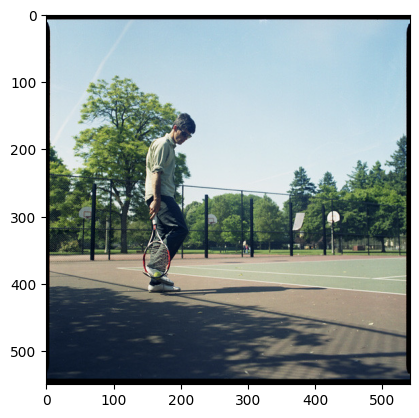

In [6]:
sample_image = Image.open('./526736409_b5dff13989_z.jpg').convert(mode="RGB")
plt.imshow(sample_image)

In [7]:
outputs = forward_pass(sample_image)

In [8]:
len(outputs.encoder_attentions)

12

In [9]:
outputs.encoder_attentions[0].shape

torch.Size([1, 12, 197, 197])

In [10]:
len(outputs.encoder_hidden_states)

13

In [11]:
outputs.encoder_hidden_states[0].shape

torch.Size([1, 197, 768])

### mask extraction
**Options:**
* Object 1: 
    * biggest object in MAIN class
    * merge all masks of MAIN class into one
* Object 2 
    * biggest object in SECONDARY class
    * merge all masks of SECONDARY class into one
* ...

In [12]:
COCO_PATH = "../../../datasets/coco"

In [13]:
with open("../task1_person_accessory_data.json", "r") as f:
    person_annotations = json.load(f)

In [14]:
person_annotations.keys()

dict_keys(['27', '28', '31', '32', '33'])

In [15]:
# sample_image_ann['annotations']['annotations']

In [16]:
sample_image.size

(541, 550)

In [18]:
# TODO: 
# * proximity between objects
# * objects closer to the main cluster of activation

def get_objects_mask(annotation, objects=[], option=1):
#     sample_image_ann = person_annotations['27'][11]
    sample_image = Image.open(os.path.join(COCO_PATH, 'train2017', annotation['image']['file_name'])).convert('RGB')    
    masks = []
    for obj in objects:
        pil_mask = np.zeros(shape=sample_image.size, dtype=np.uint8)
        pil_mask = Image.fromarray(np.moveaxis(pil_mask, 0, -1))
        img_draw = ImageDraw.Draw(pil_mask) 
        
        # select main (largest) mask for the person class
        if option == 1:
            objects_area = [ann['area'] for ann in annotation['annotations']['annotations'] if ann['category_id']==obj]
            segmentation = [ann['segmentation'] for ann in annotation['annotations']['annotations'] if ann['area']==np.max(objects_area)]
            for segment in segmentation[0]:
                print(segment)
                img_draw.polygon(segment, fill ="#ffffff")

        # merge all masks of the object class into one
        if option == 2:
            segmentation = [ann['segmentation'] for ann in annotation['annotations']['annotations'] if ann['category_id']==obj]
            for segment in segmentation:
                if isinstance(segment, list):
                    img_draw.polygon(segment[0], fill ="#ffffff")
                    
        if option == 3:
            pass
        
        masks.append(pil_mask)
    return masks

In [19]:
## 

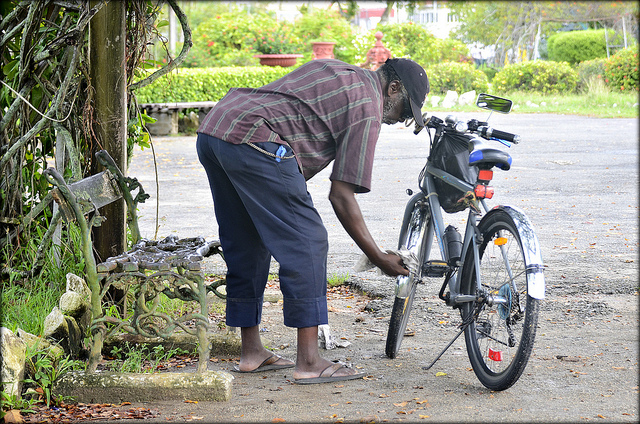

In [102]:
sample_ann = person_annotations['27'][11]
sample_img = Image.open(os.path.join(COCO_PATH, 'train2017', sample_ann['image']['file_name'])).convert('RGB')    
sample_img

2
(424, 640)


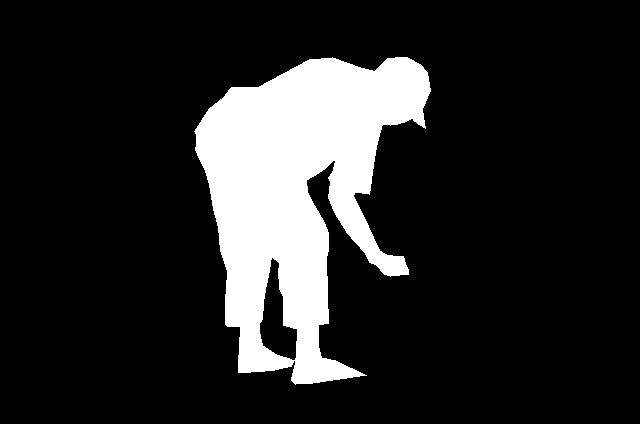

In [103]:
masks = get_objects_mask(sample_ann, objects=[1, 27], option=2)
print(len(masks))
print(np.array(masks[0]).shape)
masks[0]

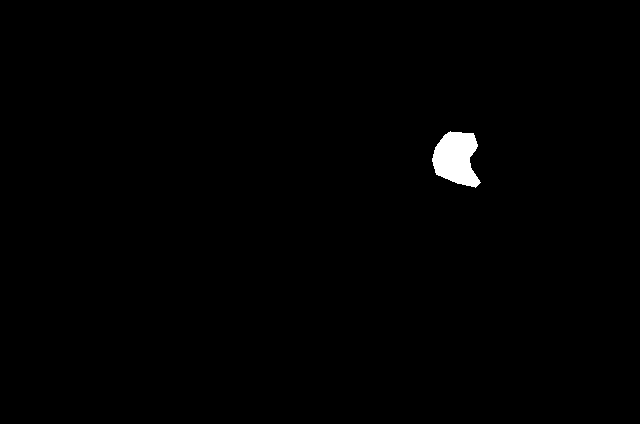

In [104]:
masks[1]

### Relevant token extraction

In [105]:
#grid_size = int(np.sqrt(mean_att_map[:,1:,1:].size(-1)))
grid_size = 14

In [106]:
ar = np.zeros((16,16,1))
ar.shape

(16, 16, 1)

In [91]:
len(ar.flatten())

256

In [115]:
def is_patch_bg(original_img_mask, patch_coord, bg_threshold=.75):
    patch_with_mask = original_img_mask[patch_coord[0]:patch_coord[1], patch_coord[2]:patch_coord[3],:]
    # previously was dividing by 768, why? 768 is the embbedding size...
    perc_bg = len(patch_with_mask[patch_with_mask==0]) / len(patch_with_mask.flatten())

    return perc_bg > bg_threshold, patch_with_mask

def find_original_img_patch(vit_patch:int, original_img, grid_size:int=14, patch_size:int=16):
#     h_p, w_p = vit_patch
#     projection = original_img[h_p * patch_size:(h_p * patch_size)+patch_size, w_p * patch_size:(w_p * patch_size)+patch_size]
    col_p = vit_patch // grid_size
    row_p = vit_patch - (col_p * grid_size)
    y = row_p * patch_size
    width = patch_size
    x = col_p * patch_size
    height = patch_size
    projection = original_img[x:x+width, y:y+height]
    return projection, (x, x+width, y, y+height)

### Find BG tokens

In [191]:
def find_consistent_bg_token(attention_map, original_img, original_bg_mask, n_layers=-3, min_n=3, max_n=20):
    all_top_n = []    
    for idx, layer in enumerate(attention_map[n_layers:, :, :]):    
        bg_mask_patch = np.ones((196), dtype="bool")
        for patch in range(len(layer[0, 1:])):
            img_patch, coord = find_original_img_patch(patch, original_img)
            bg_mask_patch[patch] = is_patch_bg(original_bg_mask, coord)[0]

        # set all fg activation to 0
        img_map_bg = copy.deepcopy(layer[0, 1:].cpu().detach().numpy())
        img_map_bg[~bg_mask_patch] = 0

        # get top N activations of the layer    
        # based on https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        top_n = np.argpartition(img_map_bg, -1 * max_n)[-1 * max_n:]
        top_n = top_n[np.argsort(img_map_bg[top_n])]
        top_n = top_n[::-1]
        all_top_n.append(top_n)    

    
    # find if there's intersection with previous layer
    for n in range(min_n, max_n, 2):
        common_tokens = set()
        for layer_no, layer_top_n in enumerate(all_top_n):
            if layer_no==0:
                common_tokens = set(layer_top_n[:n])                
            else:
                common_tokens = common_tokens.intersection(set(layer_top_n[:n]))
                if not common_tokens:
                    print(f"No common token with top {n}")
                    break
        if common_tokens:
#             print(f"found common tokens with top {n}")
            bg_token = list(common_tokens)
            if len(bg_token)>1:
                # sum selected tokens across all layers to get top 1
                sums = dict(zip(bg_token, [0] * len(bg_token)))
                for layer in attention_map[n_layers:, :, :]:
                    for token in bg_token:
                        sums[token] += layer[0, token].cpu().detach().numpy()
#                 print(sums)
                bg_token = max(sums, key=sums.get)
#                 print(bg_token)
            else:
                bg_token = bg_token[0]
            break
            
    return bg_token, all_top_n

### Get FG tokens:
1. Maximum and minimum attention token in the region for object 1. 
2. Maximum and minimum attention token from object 2. 
3. A Random token each from both objects. 
4. Max token from the whole image
5. The token consistently paid attention in last 3 layers. (from the whole image? or just FG?)

All the tokens are per layer, is it the best way to do?

In [192]:
def xy_coord_token(token, grid_size=14):
    y = token // grid_size
    x = token - (y * grid_size)
    return x, y

def find_fg_tokens(attention_map, original_img, original_bg_mask, n_layers=-3, display_token_grid=False):
    tokens = []
    
    if display_token_grid:
        plt.figure(figsize=(6, 6))
        plt.imshow(original_img)
        plt.show()
        plt.figure(figsize=(6, 6))
        plt.imshow(original_bg_mask)
        plt.show()
        fig, axs = plt.subplots(nrows=14, ncols=14, figsize=(6, 6))
    
    for idx, layer in enumerate(attention_map[n_layers:, :, :]):
        tokens_layer_i = {}
        fg_mask_patch = np.zeros((196), dtype="bool")
        fg_tokens = []
        # iterate through all 196 patches of images
        for patch_i in range(len(layer[0, 1:])):
            img_patch, coord = find_original_img_patch(patch_i, original_img)
            fg_mask_patch[patch_i] = not is_patch_bg(original_bg_mask, coord)[0]
            if fg_mask_patch[patch_i]:
                fg_tokens.append(patch_i)
            
            if display_token_grid:
                row_p, col_p = xy_coord_token(patch_i)
                if fg_mask_patch[patch_i]:
                    axs[col_p, row_p].imshow(img_patch)                       
                else:
                    axs[col_p, row_p].imshow(np.zeros_like(img_patch))
                axs[col_p, row_p].axis('off')
                
        # MAX token whole image
        tokens_layer_i['max_image'] = np.argmax(layer[0, 1:].cpu().detach().numpy())
        
        # set all background activation WITHIN background mask to -1
        # PS technically don't need to set anything to 0, just slice the image map with fg_mask
        # but for visualization purposes is needed to highligh the tokens belonging to the FG
        img_map_fg = copy.deepcopy(layer[0, 1:].cpu().detach().numpy())
        img_map_fg[~fg_mask_patch] = 0
        
        # MIN MAX token within object
        max_token_obj_layer_i = np.argmax(img_map_fg)
        # TODO: Improve logic to get min attention token considering only one region. 
        # when slicing np.array and using np.argmin the index returned is not relative to original array anymore
        # e.g.: np.argmin(img_map_fg[fg_mask_patch]) will return an index relative to the new array img_map_fg[fg_mask_patch]
        min_token_obj_layer_i = -1
        min_activation = np.max(img_map_fg)
        for token_i in fg_tokens:
            if img_map_fg[token_i] < min_activation:
                min_token_obj_layer_i = token_i
                min_activation = img_map_fg[token_i]

        tokens_layer_i['max_obj'] = max_token_obj_layer_i
        tokens_layer_i['min_obj'] = min_token_obj_layer_i
        
        # RANDOM token within object
        tokens_layer_i['random_obj'] = random.choice(fg_tokens)
        
        tokens.append(tokens_layer_i)

        if display_token_grid:
            # show grid with all tokens found
            plt.show()
            plt.figure(figsize=(3, 3))
#             plt.imshow(layer[0, 1:].cpu().detach().numpy().reshape(grid_size, grid_size))
            plt.imshow(img_map_fg.reshape(grid_size, grid_size))
            plt.title(f"layer {idx}, shape {img_map_fg.shape} ")
            row_p, col_p = xy_coord_token(tokens_layer_i['min_obj'])
            plt.scatter(row_p, col_p, marker='_', c='blue')
            row_p, col_p = xy_coord_token(tokens_layer_i['max_obj'])
            plt.scatter(row_p, col_p, marker='+', c='red')
            row_p, col_p = xy_coord_token(tokens_layer_i['random_obj'])
            plt.scatter(row_p, col_p, marker='*', c='green')
            row_p, col_p = xy_coord_token(tokens_layer_i['max_image'])
            plt.scatter(row_p, col_p, marker='P', c='orange')
            plt.show()

    return tokens

### Attention map extraction

In [195]:
def extract_bg_token(img: Image.Image, mask:np.array, renorm_weights=True):
#     x = transform(img)
#     logits, att_map, layer_activations = model(x.unsqueeze(0))    
    ################################################
    outputs = forward_pass(img)
    layer_activations = outputs.encoder_hidden_states
    
    att_map = outputs.encoder_attentions    
    att_map = torch.stack(att_map)
    att_map = att_map.squeeze(1)

    # Average the attention weights across all heads.
    att_map = torch.mean(att_map, dim=1)
    mean_att_map = att_map
    
    grid_size = int(np.sqrt(mean_att_map[:,1:,1:].size(-1)))
    print(grid_size)
    
    if renorm_weights:
        residual_att = torch.eye(mean_att_map.size(1))
        residual_att = residual_att.to(device)
        aug_mean_map = mean_att_map + residual_att
        aug_mean_map = aug_mean_map / aug_mean_map.sum(dim=-1).unsqueeze(-1)
        mean_att_map = aug_mean_map
        
    # some regions of the image have intermediate values between 0 and 255
    # maybe resizing the image create these "intermediate" pixels.
    mask_img = copy.deepcopy(mask)
    mask_img[mask_img==255] = 255
    mask_img[mask_img!=255] = 0
    mask_img = mask_img[:,:,np.newaxis]
    
#     plt.imshow(mask_img)
#     plt.show()
        
    bg_token, _ = find_consistent_bg_token(mean_att_map, np.array(img), mask_img)
    fg_tokens = find_fg_tokens(mean_att_map, np.array(img), mask_img, display_token_grid=False)
    
    return bg_token, fg_tokens, mean_att_map, layer_activations

In [196]:
bg_token, fg_obj_tokens, mean_att_map, layer_activations= extract_bg_token(img=sample_img.resize((224,224)), 
                                                                           mask=np.array(masks[0].resize((224,224))))

14
No common token with top 3
No common token with top 5


In [197]:
bg_token

5

In [198]:
fg_obj_tokens

[{'max_image': 5, 'max_obj': 36, 'min_obj': 34, 'random_obj': 91},
 {'max_image': 5, 'max_obj': 50, 'min_obj': 146, 'random_obj': 74},
 {'max_image': 80, 'max_obj': 120, 'min_obj': 46, 'random_obj': 51}]

In [ ]:
# Display tokens
# plt.imshow(mean_att_map[-1,0,1:].cpu().detach().numpy().reshape(grid_size, grid_size))
# col_p = token // grid_size
# row_p = token - (col_p * grid_size)
# plt.scatter(row_p, col_p, marker='*', c='red')